In [1]:
N_JOBS = 10
N_MACHINES = 4

In [2]:
random_seed = 6725

In [3]:
import random

def generateData(seed=0):
    PROC = [ [ 0 for m in range(N_MACHINES) ] for j in range(N_JOBS) ]
    random.seed(seed)
    for j in range(N_JOBS):
        for m in range(N_MACHINES):
            PROC[j][m] = random.randint(1,9)
    return PROC

In [4]:
PROC = generateData(random_seed)

In [5]:
PROC

[[1, 2, 6, 2],
 [8, 1, 4, 9],
 [4, 5, 4, 8],
 [4, 6, 3, 5],
 [5, 6, 8, 5],
 [4, 3, 8, 3],
 [2, 2, 7, 8],
 [4, 9, 1, 7],
 [7, 1, 8, 8],
 [2, 3, 6, 5]]

## IP solution

In [6]:
import pulp

In [7]:
def val(x):
    return int(pulp.value(x))

In [8]:
prob = pulp.LpProblem("JobScheduling",pulp.LpMinimize)

`J[j]` defines the sequencing of jobs 'j' and is just a permutation of the job number:

In [9]:
JJ = pulp.LpVariable.dicts("J", (range(N_JOBS), range(N_JOBS)),
                           lowBound=0, upBound=1, cat='Integer')

In [10]:
def job(n):
    for j in range(N_JOBS):
        if val(JJ[n][j])==1:
            return j

In [11]:
def jobSequence():
    acc = []
    for j in range(N_JOBS):
        for jj in range(N_JOBS):
            if pulp.value(JJ[j][jj])==1:
                acc.append(jj)
    return acc

In [12]:
def proc(job, machine):
    global PROC
    return pulp.lpSum( [ PROC[j][machine] * JJ[j][job] for j in range(N_JOBS) ] ) 

`WAIT[j][m]` describes the wait time of job `j` before machine `m`

In [13]:
Wait = pulp.LpVariable.dicts("WAIT", (range(N_JOBS), range(N_MACHINES)),
                          lowBound=0, cat='Integer')

`IDLE[j][m]` describes the idle time of machine `m` before processing job `j` 

In [14]:
Idle = pulp.LpVariable.dicts("IDLE", (range(N_JOBS), range(N_MACHINES)),
                             lowBound=0, cat='Integer')

`START[j][m]` describes the start time of machine `m` processing job `j`

In [15]:
Start = pulp.LpVariable.dicts("START", (range(N_JOBS), range(N_MACHINES)),
                          lowBound=0, cat='Integer')

`STOP[j][m]` describes the stop time of machine `m` after processing job `j`

In [16]:
Stop = pulp.LpVariable.dicts("STOP", (range(N_JOBS), range(N_MACHINES)),
                          lowBound=0, cat='Integer')

In [17]:
prob += Stop[N_JOBS-1][N_MACHINES-1]

In [18]:
for j in range(N_JOBS):
    prob += pulp.lpSum( [ JJ[j][jj] for jj in range(N_JOBS) ] ) == 1
    prob += pulp.lpSum( [ JJ[jj][j] for jj in range(N_JOBS) ] ) == 1

In [19]:
for m in range(N_MACHINES):
    for j in range(N_JOBS):
        prob += pulp.lpSum( [ Idle[ji][m] + proc(ji, m) for ji in range(j) ] ) + Idle[j][m] == Start[j][m]

In [20]:
for m in range(N_MACHINES):
    for j in range(N_JOBS):
        prob += pulp.lpSum( [ Wait[j][mi] + proc(j, mi) for mi in range(m) ] ) + Wait[j][m] == Start[j][m]

In [21]:
for j in range(N_JOBS):
    for m in range(N_MACHINES):
        prob += Start[j][m] + proc(j,m) == Stop[j][m]

In [22]:
solvers = pulp.listSolvers(onlyAvailable=True) 
solver = pulp.getSolver(solvers[0], msg=0)
prob.solve(solver)

1

In [23]:
def schedule():
    row = ""
    row += '|---------|'
    for m in range(N_MACHINES):
        row += f"------------|" \
                f"------------|"
    row += '\n'
    row += '|         |'
    for m in range(N_MACHINES):
        row += f"            |" \
                f" Machine: {m:1d} |"
    row += '\n'
    for j in range(N_JOBS):
        row += '|---------|'
        for m in range(N_MACHINES):
            row += f"------------|" \
                   f"------------|"
        row += '\n'
        row += '|         |'
        for m in range(N_MACHINES):
            row += f"       {' ':4s} | " \
                   f"Idle: {val(Idle[j][m]):4d} |"
        row += '\n'
        row += '|---------|'
        for m in range(N_MACHINES):
            row += f"------------|" \
                   f"------------|"
        row += '\n'
        row += '|         |'
        for m in range(N_MACHINES):
            row += f"       {' ':4s} | " \
                   f"Start:{val(Start[j][m]):4d} |"  
        row += '\n' 
        row += f'| Job: {job(j):2d} |'
        for m in range(N_MACHINES):
            row += f" Wait: {val(Wait[j][m]):4d} | " \
                   f"Proc: {val(proc(j,m)):4d} |"
        row += '\n'
        row += '|         |'
        for m in range(N_MACHINES):
            row += f"       {' ':4s} | " \
                   f"Stop: {val(Stop[j][m]):4d} |"  
        row += '\n' 
    row += '|---------|'
    for m in range(N_MACHINES):
        row += f"------------|" \
                f"------------|"
    row += '\n'
    return row

The processing times per job and machine:

In [24]:
PROC

[[1, 2, 6, 2],
 [8, 1, 4, 9],
 [4, 5, 4, 8],
 [4, 6, 3, 5],
 [5, 6, 8, 5],
 [4, 3, 8, 3],
 [2, 2, 7, 8],
 [4, 9, 1, 7],
 [7, 1, 8, 8],
 [2, 3, 6, 5]]

The optimal job schedule:

In [25]:
print(jobSequence())

[3, 2, 4, 8, 5, 9, 6, 1, 7, 0]


The processing time of the optimal job schedule:

In [26]:
int(pulp.value(prob.objective))

71

The optimal job schedule in detail:

In [27]:
print(schedule())

|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    2 |            | Idle:    5 |            | Idle:   11 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   2 |            | Start:   5 |            | Start:  11 |
| Job:  3 | Wait:    0 | Proc:    2 | Wait:    0 | Proc:    3 | Wait:    0 | Proc:    6 | Wait:    0 | Proc:    5 |
|         |            | Stop:    2 |            | Stop:    5 |            | Stop:   11 |            | Stop:   16 |
|---------|------------|------------|------------|------------|---------

### Greedy algorithm 

In [28]:
def greedy_algorithm(proc):
    n_jobs, n_machines = len(proc), len(proc[0])
    machine_end_times = [0] * n_machines
    schedule = [[] for _ in range(n_jobs)]

    job_sequence = []  # Record the actual job scheduling sequence

    for _ in range(n_jobs):
        # Find the job with the earliest completion time if scheduled on any machine
        min_completion_time = float('inf')
        min_job_index = -1
        for job_index in range(n_jobs):
            if job_index not in job_sequence:
                for machine in range(n_machines):
                    if machine == 0:
                        start_time = machine_end_times[machine]
                    else:
                        if len(schedule[job_index]) == 0:
                            start_time = machine_end_times[machine]
                        else:
                            start_time = max(machine_end_times[machine], schedule[job_index][machine-1][1])

                    completion_time = start_time + proc[job_index][machine]
                    if completion_time < min_completion_time:
                        min_completion_time = completion_time
                        min_job_index = job_index

        # Schedule the selected job
        job_sequence.append(min_job_index)
        for machine in range(n_machines):
            if machine == 0:
                start_time = machine_end_times[machine]
            else:
                if len(schedule[min_job_index]) == 0:
                    start_time = machine_end_times[machine]
                else:
                    start_time = max(machine_end_times[machine], schedule[min_job_index][machine-1][1])

            end_time = start_time + proc[min_job_index][machine]
            schedule[min_job_index].append((start_time, end_time))
            machine_end_times[machine] = end_time

    makespan = max(machine_end_times)

    return job_sequence, makespan, schedule

# Call the greedy_algorithm function
job_sequence, makespan, schedule = greedy_algorithm(PROC)


In [29]:
def print_schedule_details(schedule, proc, job_sequence):
    total_processing_time = 0
    total_wait_time = 0
    total_idle_time = 0

    for job_index in job_sequence:
        job_schedule = schedule[job_index]
        print("Job", job_index, ":", job_schedule)
        for machine_index, (start_time, end_time) in enumerate(job_schedule):
            total_processing_time += proc[job_index][machine_index]
            if machine_index == 0:
                total_wait_time += start_time
            else:
                total_wait_time += max(0, start_time - job_schedule[machine_index - 1][1])
            if machine_index > 0:
                total_idle_time += max(0, start_time - job_schedule[machine_index - 1][1])

# Call the greedy_algorithm function
job_sequence, makespan, schedule = greedy_algorithm(PROC)

# Print the job sequence as an array
print("Job Sequence:", job_sequence)
print("Total Processing time:", makespan)

# Print the schedule details
print("Schedule Details /each machine start and end time/:")
print_schedule_details(schedule, PROC, job_sequence)


Job Sequence: [0, 6, 9, 1, 8, 2, 3, 5, 7, 4]
Total Processing time: 74
Schedule Details /each machine start and end time/:
Job 0 : [(0, 1), (1, 3), (3, 9), (9, 11)]
Job 6 : [(1, 3), (3, 5), (9, 16), (16, 24)]
Job 9 : [(3, 5), (5, 8), (16, 22), (24, 29)]
Job 1 : [(5, 13), (13, 14), (22, 26), (29, 38)]
Job 8 : [(13, 20), (20, 21), (26, 34), (38, 46)]
Job 2 : [(20, 24), (24, 29), (34, 38), (46, 54)]
Job 3 : [(24, 28), (29, 35), (38, 41), (54, 59)]
Job 5 : [(28, 32), (35, 38), (41, 49), (59, 62)]
Job 7 : [(32, 36), (38, 47), (49, 50), (62, 69)]
Job 4 : [(36, 41), (47, 53), (53, 61), (69, 74)]


In [30]:
def greedy_algorithm_with_times(proc):
    n_jobs, n_machines = len(proc), len(proc[0])
    machine_end_times = [0] * n_machines
    schedule = [[] for _ in range(n_jobs)]

    job_sequence = []  # Record the actual job scheduling sequence

    idle_times = [[] for _ in range(n_jobs)]  # Initialize idle times for each job
    wait_times = [[] for _ in range(n_jobs)]  # Initialize wait times for each job

    for _ in range(n_jobs):
        # Find the job with the earliest completion time if scheduled on any machine
        min_completion_time = float('inf')
        min_job_index = -1
        for job_index in range(n_jobs):
            if job_index not in job_sequence:
                for machine in range(n_machines):
                    if machine == 0:
                        start_time = machine_end_times[machine]
                    else:
                        if len(schedule[job_index]) == 0:
                            start_time = machine_end_times[machine]
                        else:
                            start_time = max(machine_end_times[machine], schedule[job_index][machine-1][1])

                    completion_time = start_time + proc[job_index][machine]
                    if completion_time < min_completion_time:
                        min_completion_time = completion_time
                        min_job_index = job_index

        # Schedule the selected job
        job_sequence.append(min_job_index)
        for machine in range(n_machines):
            if machine == 0:
                start_time = machine_end_times[machine]
            else:
                if len(schedule[min_job_index]) == 0:
                    start_time = machine_end_times[machine]
                else:
                    start_time = max(machine_end_times[machine], schedule[min_job_index][machine-1][1])

            end_time = start_time + proc[min_job_index][machine]
            schedule[min_job_index].append((start_time, end_time))

            # Calculate idle time and wait time
            prev_machine_end_time = machine_end_times[machine - 1] if machine > 0 else 0
            prev_job_end_time = machine_end_times[machine]

            wait_time = max(0, prev_job_end_time - prev_machine_end_time)
            idle_time = max(0, prev_machine_end_time - prev_job_end_time)

            idle_times[min_job_index].append(idle_time)
            wait_times[min_job_index].append(wait_time)

            machine_end_times[machine] = end_time

    makespan = max(machine_end_times)

    return job_sequence, makespan, schedule, idle_times, wait_times

# Call the greedy_algorithm_with_times function
job_sequence, makespan, _, idle_times, wait_times = greedy_algorithm_with_times(PROC)

print("Job sequence:", job_sequence)
print("Makespan:", makespan)

print("\nIdle Time:")
for job in job_sequence:
    print(f"Job {job}: {idle_times[job]}")

print("\nWait Time:")
for job in job_sequence:
    print(f"Job {job}: {wait_times[job]}")



Job sequence: [0, 6, 9, 1, 8, 2, 3, 5, 7, 4]
Makespan: 74

Idle Time:
Job 0: [0, 1, 3, 9]
Job 6: [0, 0, 0, 5]
Job 9: [0, 0, 0, 0]
Job 1: [0, 5, 0, 0]
Job 8: [0, 6, 0, 0]
Job 2: [0, 3, 0, 0]
Job 3: [0, 0, 0, 0]
Job 5: [0, 0, 0, 0]
Job 7: [0, 0, 0, 0]
Job 4: [0, 0, 3, 0]

Wait Time:
Job 0: [0, 0, 0, 0]
Job 6: [1, 0, 4, 0]
Job 9: [3, 0, 8, 2]
Job 1: [5, 0, 8, 3]
Job 8: [13, 0, 5, 4]
Job 2: [20, 0, 5, 8]
Job 3: [24, 1, 3, 13]
Job 5: [28, 3, 3, 10]
Job 7: [32, 2, 2, 12]
Job 4: [36, 6, 0, 8]


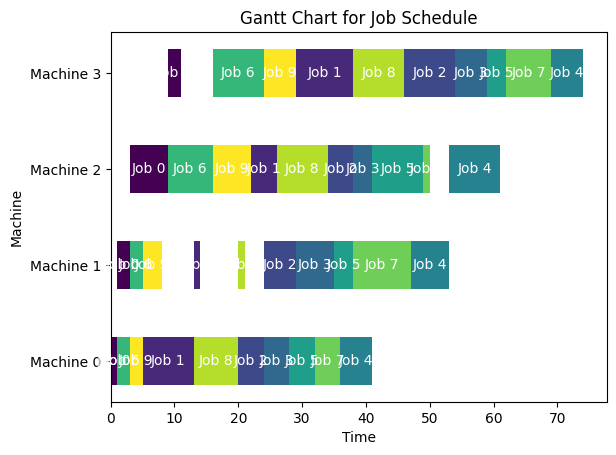

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gantt_chart(schedule):
    fig, ax = plt.subplots()

    # Set plot title and labels
    ax.set_title('Gantt Chart for Job Schedule')
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')

    # Define colors for lines dynamically based on the number of jobs
    n_jobs = len(schedule)
    colors = plt.cm.viridis(np.linspace(0, 1, n_jobs))  # Generate colors from colormap

    # Plot each job's schedule
    for job_index, job_schedule in enumerate(schedule):
        for machine_index, (start_time, end_time) in enumerate(job_schedule):
            ax.barh(machine_index, end_time - start_time, left=start_time, height=0.5, align='center', color=colors[job_index])
            ax.text(start_time + (end_time - start_time) / 2, machine_index, f'Job {job_index}', ha='center', va='center', color='white')

    # Set y-axis ticks and labels
    ax.set_yticks(np.arange(len(schedule[0])))
    ax.set_yticklabels([f'Machine {i}' for i in range(len(schedule[0]))])

    # Show plot
    plt.show()

# Call the greedy_algorithm function
job_sequence, makespan, schedule = greedy_algorithm(PROC)

# Plot Gantt chart
plot_gantt_chart(schedule)


## Genetic algorithm


In [32]:
import numpy as np
import random

# Initialize parameters
POP_SIZE = 50        # Population size
GEN_MAX = 200        # Maximum generations
MUTATION_RATE = 0.1  # Mutation rate
CROSSOVER_RATE = 0.8 # Crossover rate

# Seed for reproducibility
random_seed = 6725
random.seed(random_seed)
np.random.seed(random_seed)

# Save random state
random_state = random.getstate()

def genetic_algorithm(proc,seed=6725):
    n_jobs, n_machines = len(proc), len(proc[0])


    def initialize_population():
        return [np.random.permutation(n_jobs) for _ in range(POP_SIZE)]

    # Restoring random state
    random.setstate(random_state)

    def calculate_makespan(individual):
        machine_times = np.zeros(n_machines)
        for j in individual:
            for m in range(n_machines):
                start_time = machine_times[m - 1] if m > 0 else 0
                machine_times[m] = max(machine_times[m], start_time) + proc[j][m]
        return max(machine_times)

    def selection(population, fitnesses):
        # Avoid issues caused by zero or negative fitness
        min_fitness = min(fitnesses)
        if min_fitness <= 0:
            fitnesses = [f + abs(min_fitness) + 1 for f in fitnesses]  # Ensure all fitnesses are positive

        # Calculate inverse fitness and normalize probabilities
        inverted_fitnesses = [1.0 / f for f in fitnesses]
        total_fitness = sum(inverted_fitnesses)
        if total_fitness == 0 or not np.isfinite(total_fitness):
            # If the total sum is zero or infinite, evenly distribute probabilities
            selection_probs = [1 / len(fitnesses)] * len(fitnesses)
        else:
            selection_probs = [f / total_fitness for f in inverted_fitnesses]

        # Check if probability array contains NaNs
        if np.isnan(selection_probs).any():
            raise ValueError("Probabilities contain NaNs")

        selected_indices = np.random.choice(range(len(population)), size=len(population), replace=True, p=selection_probs)
        return [population[i] for i in selected_indices]

    def crossover(parent1, parent2):
        if random.random() < CROSSOVER_RATE:
            cut1, cut2 = sorted(random.sample(range(1, n_jobs), 2))
            middle = parent1[cut1:cut2]
            child = [gene for gene in parent2 if gene not in middle]
            child[cut1:cut1] = middle
            return np.array(child)
        return parent1.copy()  # Return a copy to avoid modifying the parent

    
    # Call this new perform_crossover function in the main loop.
    def perform_crossover(selected):
        next_population = []
        for i in range(0, len(selected) - 1, 2):
            next_population.append(crossover(selected[i], selected[i + 1]))
            next_population.append(crossover(selected[i + 1], selected[i]))
        if len(selected) % 2 == 1:  # If odd number of individuals
            next_population.append(selected[-1])  # Just carry the last one over
        return next_population

    def mutate(individual):
        if random.random() < MUTATION_RATE:
            idx1, idx2 = random.sample(range(n_jobs), 2)
            individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

    population = initialize_population()
    best_solution = None
    best_fitness = float('inf')

    for generation in range(GEN_MAX):
        fitnesses = [calculate_makespan(individual) for individual in population]
        best_index = np.argmin(fitnesses)
        if fitnesses[best_index] < best_fitness:
            best_fitness = fitnesses[best_index]
            best_solution = population[best_index]

        selected = selection(population, fitnesses)
        # Make sure the population size remains constant after each crossover, even if the number of individuals is odd, to resolve issues where the population size was halved due to the crossover operation.
        population = perform_crossover(selected)
        for individual in population:
            mutate(individual)

    # Calculate makespan based on the end time of the last job
    job_schedule = calculate_job_schedule(best_solution, proc)
    last_job_end_times = [machine[-1][-1] for machine in job_schedule]
    makespan = max(last_job_end_times)
    
    # Restore random state
    random.setstate(random_state)

    return best_solution, best_fitness, makespan


def calculate_job_schedule(best_solution, proc):
    n_jobs, n_machines = len(proc), len(proc[0])
    machine_times = np.zeros(n_machines)  # Initialize machine times
    
    job_schedule = [[] for _ in range(n_jobs)]  # Initialize job schedule
    
    for job in best_solution:
        for machine in range(n_machines):
            # Determine the start time based on the end time of the previous task on the same machine
            start_time = max(machine_times[machine], machine_times[machine - 1] if machine > 0 else 0)
            machine_times[machine] = start_time + proc[job][machine]  # Update machine time
            end_time = machine_times[machine]  # End time of current job on current machine
            job_schedule[job].append((machine, start_time, end_time))  # Append machine, start time, and end time to job schedule
    
    return job_schedule

# Run genetic algorithm
best_solution, best_fitness, makespan = genetic_algorithm(PROC,seed=6725)  # Obtain the best solution from genetic algorithm
job_schedule = calculate_job_schedule(best_solution, PROC)  # Calculate detailed job schedule

print("Job sequence:", best_solution)
print("Processing time:", makespan)

Job sequence: [6 8 3 9 1 2 5 4 0 7]
Processing time: 71.0


In [33]:
def print_job_schedule(schedule, job_sequence):
    for job_index in job_sequence:
        task_info = ', '.join([f"({int(start)}, {int(end)})" 
                               for (_, start, end) in schedule[job_index]])
        print(f"Job {job_index} : {task_info}")

# Call the print_job_schedule function
print_job_schedule(job_schedule, best_solution)


Job 6 : (0, 2), (2, 4), (4, 11), (11, 19)
Job 8 : (2, 9), (9, 10), (11, 19), (19, 27)
Job 3 : (9, 13), (13, 19), (19, 22), (27, 32)
Job 9 : (13, 15), (19, 22), (22, 28), (32, 37)
Job 1 : (15, 23), (23, 24), (28, 32), (37, 46)
Job 2 : (23, 27), (27, 32), (32, 36), (46, 54)
Job 5 : (27, 31), (32, 35), (36, 44), (54, 57)
Job 4 : (31, 36), (36, 42), (44, 52), (57, 62)
Job 0 : (36, 37), (42, 44), (52, 58), (62, 64)
Job 7 : (37, 41), (44, 53), (58, 59), (64, 71)


In [34]:
def calculate_job_schedule_with_times(best_solution, proc):
    n_jobs, n_machines = len(proc), len(proc[0])
    machine_times = np.zeros(n_machines)  # Initialize machine times

    idle_times = [[] for _ in range(n_jobs)]  # Initialize idle times for each job
    wait_times = [[] for _ in range(n_jobs)]  # Initialize wait times for each job

    for job in best_solution:
        for machine in range(n_machines):
            # Determine the start time based on the end time of the previous task on the same machine
            prev_machine_end_time = machine_times[machine - 1] if machine > 0 else 0
            prev_job_end_time = machine_times[machine]

            wait_time = int(max(0, prev_job_end_time - prev_machine_end_time))
            idle_time = int(max(0, prev_machine_end_time - prev_job_end_time))

            idle_times[job].append(idle_time)
            wait_times[job].append(wait_time)

            start_time = max(prev_job_end_time, prev_machine_end_time)
            machine_times[machine] = start_time + proc[job][machine]  # Update machine time

    return idle_times, wait_times

idle_times, wait_times = calculate_job_schedule_with_times(best_solution, PROC)  # Calculate idle and wait times


print("\nIdle Time:")
for job in best_solution:
    print(f"Job {job}: {idle_times[job]}")

print("\nWait Time:")
for job in best_solution:
    print(f"Job {job}: {wait_times[job]}")



Idle Time:
Job 6: [0, 2, 4, 11]
Job 8: [0, 5, 0, 0]
Job 3: [0, 3, 0, 0]
Job 9: [0, 0, 0, 0]
Job 1: [0, 1, 0, 0]
Job 2: [0, 3, 0, 0]
Job 5: [0, 0, 0, 0]
Job 4: [0, 1, 0, 0]
Job 0: [0, 0, 0, 0]
Job 7: [0, 0, 0, 0]

Wait Time:
Job 6: [0, 0, 0, 0]
Job 8: [2, 0, 1, 0]
Job 3: [9, 0, 0, 5]
Job 9: [13, 4, 0, 4]
Job 1: [15, 0, 4, 5]
Job 2: [23, 0, 0, 10]
Job 5: [27, 1, 1, 10]
Job 4: [31, 0, 2, 5]
Job 0: [36, 5, 8, 4]
Job 7: [37, 3, 5, 5]


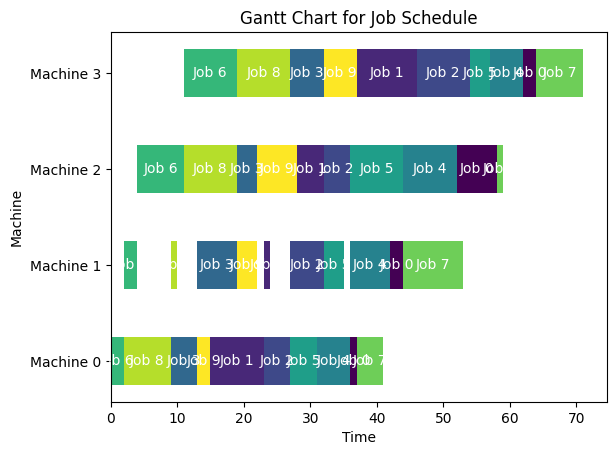

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gantt_chart(schedule):
    fig, ax = plt.subplots()

    # Set plot title and labels
    ax.set_title('Gantt Chart for Job Schedule')
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')

    # Define colors for lines dynamically based on the number of jobs
    n_jobs = len(schedule)
    colors = plt.cm.viridis(np.linspace(0, 1, n_jobs))  # Generate colors from colormap

    # Plot each job's schedule
    for job_index, job_schedule in enumerate(schedule):
        for (machine_index, start_time, end_time) in job_schedule:
            ax.barh(machine_index, end_time - start_time, left=start_time, height=0.5, align='center', color=colors[job_index])
            ax.text(start_time + (end_time - start_time) / 2, machine_index, f'Job {job_index}', ha='center', va='center', color='white')

    # Set y-axis ticks and labels
    ax.set_yticks(np.arange(len(schedule[0])))
    ax.set_yticklabels([f'Machine {i}' for i in range(len(schedule[0]))])

    # Show plot
    plt.show()

# Calculate job schedule
job_schedule = calculate_job_schedule(best_solution, PROC)

# Plot Gantt chart
plot_gantt_chart(job_schedule)


### Running the algorithms on multiple different machines

In [36]:
import random

# Define the generateData function
def generateData(seed=0, n_jobs=10, n_machines=5):
    PROC = [[0 for _ in range(n_machines)] for _ in range(n_jobs)]
    random.seed(seed)
    for j in range(n_jobs):
        for m in range(n_machines):
            PROC[j][m] = random.randint(1, 9)  # Example random processing time
    return PROC

# Define N_MACHINES
N_MACHINES = 4  # Example value

# Define the range of values for N_JOBS you want to test
N_JOBS_VALUES = [10, 20, 50, 100]  # Example values

# Generate PROC arrays for each value of N_JOBS
PROC_arrays = []
for n_jobs in N_JOBS_VALUES:
    random_seed = 6725 
    PROC = generateData(seed=random_seed, n_jobs=n_jobs, n_machines=N_MACHINES)
    PROC_arrays.append(PROC)

# Print each PROC array according to the number of machines
for idx, PROC in enumerate(PROC_arrays):
    print(f"PROC for N_JOBS = {N_JOBS_VALUES[idx]} and N_MACHINES = {N_MACHINES}:")
    for job in PROC:
        print(job)
    print("-" * 40)




PROC for N_JOBS = 10 and N_MACHINES = 4:
[1, 2, 6, 2]
[8, 1, 4, 9]
[4, 5, 4, 8]
[4, 6, 3, 5]
[5, 6, 8, 5]
[4, 3, 8, 3]
[2, 2, 7, 8]
[4, 9, 1, 7]
[7, 1, 8, 8]
[2, 3, 6, 5]
----------------------------------------
PROC for N_JOBS = 20 and N_MACHINES = 4:
[1, 2, 6, 2]
[8, 1, 4, 9]
[4, 5, 4, 8]
[4, 6, 3, 5]
[5, 6, 8, 5]
[4, 3, 8, 3]
[2, 2, 7, 8]
[4, 9, 1, 7]
[7, 1, 8, 8]
[2, 3, 6, 5]
[1, 4, 8, 9]
[8, 4, 3, 7]
[1, 3, 3, 8]
[9, 4, 5, 2]
[6, 8, 9, 1]
[5, 4, 1, 2]
[1, 9, 6, 9]
[5, 1, 6, 7]
[6, 8, 4, 9]
[4, 6, 4, 8]
----------------------------------------
PROC for N_JOBS = 50 and N_MACHINES = 4:
[1, 2, 6, 2]
[8, 1, 4, 9]
[4, 5, 4, 8]
[4, 6, 3, 5]
[5, 6, 8, 5]
[4, 3, 8, 3]
[2, 2, 7, 8]
[4, 9, 1, 7]
[7, 1, 8, 8]
[2, 3, 6, 5]
[1, 4, 8, 9]
[8, 4, 3, 7]
[1, 3, 3, 8]
[9, 4, 5, 2]
[6, 8, 9, 1]
[5, 4, 1, 2]
[1, 9, 6, 9]
[5, 1, 6, 7]
[6, 8, 4, 9]
[4, 6, 4, 8]
[4, 5, 2, 7]
[1, 6, 8, 5]
[5, 4, 3, 8]
[6, 6, 1, 9]
[6, 6, 2, 4]
[5, 1, 6, 5]
[6, 3, 3, 6]
[9, 2, 9, 7]
[9, 2, 1, 5]
[2, 5, 7, 3]
[7, 2, 2, 6]
[6

In [ ]:
import time
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
POP_SIZE = 50        # Population size
GEN_MAX = 200        # Maximum generations
MUTATION_RATE = 0.1  # Mutation rate
CROSSOVER_RATE = 0.8 # Crossover rate

# Seed for reproducibility
random_seed = 6725
random.seed(random_seed)
np.random.seed(random_seed)

# Define the range of values for N_JOBS you want to test
N_JOBS_VALUES = [10, 20, 50, 100]

def run_and_save_results(n_jobs_values, proc_arrays, num_runs=5):
    results = []

    greedy_execution_times = []
    genetic_execution_times = []
    greedy_processing_times = []
    genetic_processing_times = []

    for idx, n_jobs in enumerate(n_jobs_values):
        PROC = proc_arrays[idx]
        exec_times_greedy = []
        exec_times_genetic = []
        processing_times_greedy = []
        processing_times_genetic = []

        for _ in range(num_runs):
            # Run greedy algorithm
            start_time_greedy = time.time()
            job_sequence_greedy, makespan_greedy, schedule_greedy = greedy_algorithm(PROC)
            end_time_greedy = time.time()
            exec_time_greedy = end_time_greedy - start_time_greedy
            exec_times_greedy.append(exec_time_greedy)
            processing_times_greedy.append(makespan_greedy)

            # Run genetic algorithm
            start_time_genetic = time.time()
            best_solution_genetic, best_fitness_genetic, makespan_genetic = genetic_algorithm(PROC)
            end_time_genetic = time.time()
            exec_time_genetic = end_time_genetic - start_time_genetic
            exec_times_genetic.append(exec_time_genetic)
            processing_times_genetic.append(makespan_genetic)
            

        avg_exec_time_greedy = sum(exec_times_greedy) / len(exec_times_greedy)
        avg_exec_time_genetic = sum(exec_times_genetic) / len(exec_times_genetic)
        avg_processing_time_greedy = sum(processing_times_greedy) / len(processing_times_greedy)
        avg_processing_time_genetic = sum(processing_times_genetic) / len(processing_times_genetic)

    


        results.append({
            'Job Number': n_jobs,
            'Machine Number': N_MACHINES,
            'Greedy Algorithm': {
                'Average Execution Time': avg_exec_time_greedy,
                'Processing Time': avg_processing_time_greedy
            },
            'Genetic Algorithm': {
                'Average Execution Time': avg_exec_time_genetic,
                'Processing Time': avg_processing_time_genetic
            }
        })

        # Store execution and processing times for plotting
        greedy_execution_times.append(avg_exec_time_greedy)
        genetic_execution_times.append(avg_exec_time_genetic)
        greedy_processing_times.append(avg_processing_time_greedy)
        genetic_processing_times.append(avg_processing_time_genetic)

  # Print results for greedy algorithm
        print(f"Job Number: {n_jobs}")
        print(f"Algorithm: Greedy Algorithm")
        print(f"Latest run Job Sequence (Greedy): {job_sequence_greedy}")
        print(f"Total Processing time (Greedy): {makespan_greedy}")
        print(f"Average Execution Time (Greedy): {exec_time_greedy:.4f} seconds")
        print("-" * 40)

        # Print results for genetic algorithm
        print(f"Job Number: {n_jobs}")
        print(f"Algorithm: Genetic Algorithm")
        print(f"Latest run Job Sequence (Genetic): {best_solution_genetic}")
        print(f"Total Processing time (Genetic): {makespan_genetic}")
        print(f"Average Execution Time (Genetic): {exec_time_genetic:.4f} seconds")
        print("-" * 40)

    # Save results to CSV file
    df = pd.DataFrame(results)
    # Specify file name
    file_name = 'Multiple_different_machines.csv'
    add_header = not os.path.exists(file_name)  # Add header if file doesn't exist
    df.to_csv(file_name, index=False, mode='a', header=add_header)

    # Plot execution times
    plt.figure(figsize=(10, 5))
    plt.plot(N_JOBS_VALUES, greedy_execution_times, marker='o', label='Greedy Algorithm')
    plt.plot(N_JOBS_VALUES, genetic_execution_times, marker='o', label='Genetic Algorithm')
    plt.xlabel('Number of Jobs')
    plt.ylabel('Average Execution Time (seconds)')
    plt.title('Comparison of Execution Times')
    plt.legend()
    plt.grid(True)
    plt.savefig('execution_times_comparison.png')
    plt.show()

    # Plot processing times
    plt.figure(figsize=(10, 5))
    plt.plot(N_JOBS_VALUES, greedy_processing_times, marker='o', label='Greedy Algorithm')
    plt.plot(N_JOBS_VALUES, genetic_processing_times, marker='o', label='Genetic Algorithm')
    plt.xlabel('Number of Jobs')
    plt.ylabel('Average Processing Time')
    plt.title('Comparison of Processing Times')
    plt.legend()
    plt.grid(True)
    plt.savefig('processing_times_comparison.png')
    plt.show()

# Generate PROC arrays for each value of N_JOBS
PROC_arrays = []
for n_jobs in N_JOBS_VALUES:
    random_seed = 6725 
    PROC = generateData(seed=random_seed, n_jobs=n_jobs, n_machines=N_MACHINES)
    PROC_arrays.append(PROC)

# Call the function to run algorithms and save results
run_and_save_results(N_JOBS_VALUES, PROC_arrays, num_runs=10)


Job Number: 10
Algorithm: Greedy Algorithm
Latest run Job Sequence (Greedy): [0, 6, 9, 1, 8, 2, 3, 5, 7, 4]
Total Processing time (Greedy): 74
Average Execution Time (Greedy): 0.0000 seconds
----------------------------------------
Job Number: 10
Algorithm: Genetic Algorithm
Latest run Job Sequence (Genetic): [6 8 2 1 9 4 0 7 5 3]
Total Processing time (Genetic): 71.0
Average Execution Time (Genetic): 1.5809 seconds
----------------------------------------
Job Number: 20
Algorithm: Greedy Algorithm
Latest run Job Sequence (Greedy): [0, 10, 12, 16, 6, 9, 2, 3, 5, 7, 19, 4, 15, 17, 14, 18, 8, 1, 11, 13]
Total Processing time (Greedy): 137
Average Execution Time (Greedy): 0.0010 seconds
----------------------------------------
Job Number: 20
Algorithm: Genetic Algorithm
Latest run Job Sequence (Genetic): [12  9 15  3  1  0 16 17  7  8  6 14 13 11 18 19  2  5 10  4]
Total Processing time (Genetic): 129.0
Average Execution Time (Genetic): 1.7974 seconds
-------------------------------------